In [1]:
import pandas as pd
from datetime import timedelta
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import pickle
import os
## Project import #
from tfib.evaluations import nDCG_loss
from tfib.evaluations import network_dismantle
from tfib.utils import make_lists_same_length
from tfib.utils import plot_grid_search_heatmap
from tfib.utils import plot_dismantling_graph
from tfib.utils import datetime_to_float
from tfib.tfibengines import TFIBEngine

In [2]:
# SETTINGS #

DATASET_PATH = "data/COVID19_2023_02_22_DATASET.csv"
TRAIN_SPLIT = 0.7
VALID_SPLIT = 0.2
CREDIBILITY_THR = 35.0
USE_ORIGINAL_RTT = True # Setting to False will use the Jacobson/Karels formula for estimation.
PARALLELIZATION_ENABLED = True
NDCG_AT = 10 # Set the K for NDGC@K. If None the standard nDCG will be computed.
N_JOBS = os.cpu_count()

## Data Loading

In [3]:
dtype = {'tweet_id': str,
         'user_id': str,
         'retweeted_user_id': str,
         'retweeted_status_id': str,
         "retweeeted_user_id": str}

covid_df = pd.read_csv(DATASET_PATH, parse_dates=[1], dtype=dtype)

In [4]:
covid_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
0,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,1340325850378592257,1017807360075665408,64.5
1,1340468728534884354,2020-12-20 01:27:04+00:00,924336025387913221,ORIGIN,AUTHOR,95.0
2,1340473042129080320,2020-12-20 01:44:12+00:00,47148805,ORIGIN,AUTHOR,100.0
3,1340474125656190978,2020-12-20 01:48:31+00:00,1022891525242593280,ORIGIN,AUTHOR,5.0
4,1340477947627581440,2020-12-20 02:03:42+00:00,908206586,ORIGIN,AUTHOR,95.0
...,...,...,...,...,...,...
819947,1451536212381011970,2021-10-22 13:09:35+00:00,1329549977463508993,1450461737895989261,4758512368,39.5
819948,1451536215858155528,2021-10-22 13:09:36+00:00,1446561632105205774,1451536139131801605,1446561632105205774,82.5
819949,1451536226876526601,2021-10-22 13:09:39+00:00,712365073,1451310094461947909,1173682089637625856,12.5
819950,1451536327388942348,2021-10-22 13:10:03+00:00,1036611673,1451536158098399236,1260895357548068865,20.0


In [5]:
data_df = covid_df[covid_df.retweeted_user_id != "AUTHOR"].sort_values(by="created_at").reset_index(drop=True)
data_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
0,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,1340325850378592257,1017807360075665408,64.5
1,1340480189462134784,2020-12-20 02:12:36+00:00,2288557992,1340427316573462530,1063806444380798976,95.0
2,1340481082270085120,2020-12-20 02:16:09+00:00,1237071348662448129,1340427316573462530,1063806444380798976,95.0
3,1340481539709276163,2020-12-20 02:17:58+00:00,475234937,1340481328056332289,122733775,90.0
4,1340489259183206406,2020-12-20 02:48:39+00:00,100878763,1340427316573462530,1063806444380798976,95.0
...,...,...,...,...,...,...
371581,1451535612004216833,2021-10-22 13:07:12+00:00,1430162268,1451523072146743324,605614784,80.0
371582,1451536212381011970,2021-10-22 13:09:35+00:00,1329549977463508993,1450461737895989261,4758512368,39.5
371583,1451536215858155528,2021-10-22 13:09:36+00:00,1446561632105205774,1451536139131801605,1446561632105205774,82.5
371584,1451536226876526601,2021-10-22 13:09:39+00:00,712365073,1451310094461947909,1173682089637625856,12.5


## Datetime Format Conversion 

In [6]:
data_df = datetime_to_float(data_df, "created_at", time_unit="day")

In [7]:
data_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
0,1340468299025551360,0.000000,497188910,1340325850378592257,1017807360075665408,64.5
1,1340480189462134784,0.032813,2288557992,1340427316573462530,1063806444380798976,95.0
2,1340481082270085120,0.035278,1237071348662448129,1340427316573462530,1063806444380798976,95.0
3,1340481539709276163,0.036539,475234937,1340481328056332289,122733775,90.0
4,1340489259183206406,0.057847,100878763,1340427316573462530,1063806444380798976,95.0
...,...,...,...,...,...,...
371581,1451535612004216833,306.487396,1430162268,1451523072146743324,605614784,80.0
371582,1451536212381011970,306.489051,1329549977463508993,1450461737895989261,4758512368,39.5
371583,1451536215858155528,306.489062,1446561632105205774,1451536139131801605,1446561632105205774,82.5
371584,1451536226876526601,306.489097,712365073,1451310094461947909,1173682089637625856,12.5


## Train and Test Split

In [8]:
# Splits
cut_index = int(len(data_df)*TRAIN_SPLIT)
train_set_df = data_df.iloc[:cut_index]
test_set_df = data_df.iloc[cut_index:]

In [9]:
train_set_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
0,1340468299025551360,0.000000,497188910,1340325850378592257,1017807360075665408,64.5
1,1340480189462134784,0.032813,2288557992,1340427316573462530,1063806444380798976,95.0
2,1340481082270085120,0.035278,1237071348662448129,1340427316573462530,1063806444380798976,95.0
3,1340481539709276163,0.036539,475234937,1340481328056332289,122733775,90.0
4,1340489259183206406,0.057847,100878763,1340427316573462530,1063806444380798976,95.0
...,...,...,...,...,...,...
260105,1423657755148181512,229.559167,1229478864,1423643096491958277,150725695,95.0
260106,1423658051387629573,229.559988,1245445880540467203,1423643096491958277,150725695,95.0
260107,1423658202374328320,229.560405,418767604,1423643096491958277,150725695,95.0
260108,1423658386755891209,229.560914,3305939879,1423643087449075715,1055380681,95.0


In [10]:
test_set_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
260110,1423658679178563587,229.561725,1379066290921439234,1423650351618592771,1265542837724221443,5.0
260111,1423658713286578179,229.561817,390340887,1423643096491958277,150725695,95.0
260112,1423658712858771461,229.561817,1401847828708724738,1423632084724240388,331617619,82.5
260113,1423658759402967042,229.561944,255516922,1423643096491958277,150725695,95.0
260114,1423658785718083585,229.562014,850324301450555392,1423564315559354370,1620487452,7.5
...,...,...,...,...,...,...
371581,1451535612004216833,306.487396,1430162268,1451523072146743324,605614784,80.0
371582,1451536212381011970,306.489051,1329549977463508993,1450461737895989261,4758512368,39.5
371583,1451536215858155528,306.489062,1446561632105205774,1451536139131801605,1446561632105205774,82.5
371584,1451536226876526601,306.489097,712365073,1451310094461947909,1173682089637625856,12.5


## Tuning and Validation Split

- The model will be trained repeatedly on a Tuning set == Training set - Validation set
- The model will be evaluated each time on the same Validation set

In [11]:
# Split the train set in Tuning and Validation Set
cut_index = int(len(train_set_df)*(1-VALID_SPLIT))
tuning_set_df = train_set_df.iloc[:cut_index]
valid_set_df = train_set_df.iloc[cut_index:]

In [12]:
tuning_set_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
0,1340468299025551360,0.000000,497188910,1340325850378592257,1017807360075665408,64.5
1,1340480189462134784,0.032813,2288557992,1340427316573462530,1063806444380798976,95.0
2,1340481082270085120,0.035278,1237071348662448129,1340427316573462530,1063806444380798976,95.0
3,1340481539709276163,0.036539,475234937,1340481328056332289,122733775,90.0
4,1340489259183206406,0.057847,100878763,1340427316573462530,1063806444380798976,95.0
...,...,...,...,...,...,...
208083,1406132673400258560,181.199155,904349491,1406034516641259525,1323747268013527041,69.5
208084,1406132856347320323,181.199664,1158758131448590336,1406130798743392257,1340737374666563584,69.5
208085,1406132970310799361,181.199977,1342502335361273856,1406130697941794819,365462238,95.0
208086,1406133226389786626,181.200683,1257871742,1405937778840506373,445201884,82.5


In [13]:
valid_set_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
208088,1406133528576856066,181.201516,726721856749842436,1386744123462459394,31093748,82.5
208089,1406133685955575808,181.201956,1252122787768041472,1406005928185434120,2876249524,52.0
208090,1406133698873933825,181.201991,6012422,1406130898953818116,1231899811,82.5
208091,1406134281555038209,181.203600,983065508,1406120155139260419,388284615,95.0
208092,1406134751006801925,181.204896,831865036272439297,1405937778840506373,445201884,82.5
...,...,...,...,...,...,...
260105,1423657755148181512,229.559167,1229478864,1423643096491958277,150725695,95.0
260106,1423658051387629573,229.559988,1245445880540467203,1423643096491958277,150725695,95.0
260107,1423658202374328320,229.560405,418767604,1423643096491958277,150725695,95.0
260108,1423658386755891209,229.560914,3305939879,1423643087449075715,1055380681,95.0


In [14]:
# Prepare data for hyper-parameter tuning
tuning_set = list(tuning_set_df.itertuples(index=False))

In [15]:
# Validation ground truth loading
from tfib.evaluations import get_retweet_network, get_optimal_ranking

# Validation retweet network
validation_retweets_network = get_retweet_network(
    valid_set_df[valid_set_df.credibility_score <= CREDIBILITY_THR],
    rt_UserID_col="retweeted_user_id",
    userID_col="user_id",
    rating_col="credibility_score")

# Validation optimal ranking
validation_optimal_ranking = get_optimal_ranking(validation_retweets_network).set_index("node")
validation_optimal_ranking

,outgoing_weight,incoming_weight
node,,
1683455144,4483.0,15.0
1248216384577953792,1791.0,0.0
245969509,723.0,10.0
1032615842,690.0,66.0
283416650,512.0,26.0
...,...,...
995796663636844544,0.0,1.0
997107768,0.0,1.0
997782892355969025,0.0,1.0


In [16]:
# Assign a combined single score to the ranking that keeps the order
validation_optimal_ranking['combined'] = (
    validation_optimal_ranking["outgoing_weight"] +
    validation_optimal_ranking["incoming_weight"] / 
    (validation_optimal_ranking["incoming_weight"].max() + 1))

validation_optimal_ranking

,outgoing_weight,incoming_weight,combined
node,,,
1683455144,4483.0,15.0,4483.082873
1248216384577953792,1791.0,0.0,1791.000000
245969509,723.0,10.0,723.055249
1032615842,690.0,66.0,690.364641
283416650,512.0,26.0,512.143646
...,...,...,...
995796663636844544,0.0,1.0,0.005525
997107768,0.0,1.0,0.005525
997782892355969025,0.0,1.0,0.005525


In [17]:
# Create the ranking in the dict format
validation_optimal_ranking = validation_optimal_ranking.to_dict()["combined"]
list(validation_optimal_ranking.items())[:10]

[('1683455144', 4483.082872928177),
 ('1248216384577953792', 1791.0),
 ('245969509', 723.0552486187845),
 ('1032615842', 690.3646408839779),
 ('283416650', 512.1436464088398),
 ('454365633', 474.0220994475138),
 ('1322629376421355521', 432.0),
 ('337767301', 423.0),
 ('910827588', 420.0),
 ('1289758279250452480', 389.0055248618784)]

## Hyperparameters Tuning (Grid Search)

In [18]:
# Alpha values to explore (importance of the past activity against the last)
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Beta values to explore (Activity deviation sensitivity)
betas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Gamma values to explore
gammas = [4.0, 2.0, 1.0, 0.0]

# Delta values to explore (Days interval)
max_days = int(tuning_set_df.created_at.iloc[-1]) #(tuning_set_df.created_at.max() - tuning_set_df.created_at.min()).days
deltas = list(range(1, 32)) + [max_days]

# if standard method is used
if USE_ORIGINAL_RTT:
    # disable beta and gamma
    betas, gammas = [-1], [-1]

# Build hyperparameters configuration set
hparams_set = []
for a in alphas:    
    for b in betas:
        for g in gammas:
            for d in deltas:
                hparams_set.append((a, b, g, d))

# Results storage
evaluated_hparams = []

# Total configurations to test
print(f"Testing {len(hparams_set)} configurations...")

# Kernel function
def test_config(alpha, beta, gamma, delta):

    # create a new model instance with params
    engine = TFIBEngine(
        reshare_key=lambda x: x[0],
        author_key=lambda x: x[2],
        original_post_key=lambda x: x[3],
        original_author_key=lambda x: x[4],
        timestamp_key=lambda x: x[1],
        flag_key=lambda x: x[5],
        credibility_threshold = CREDIBILITY_THR,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        delta=delta,
        use_original_rtt=USE_ORIGINAL_RTT,
        enable_repost_count_scaling=False)

    # fit the model
    engine.time_fit(tuning_set)

    # get the rank
    ranking = engine.get_rank()
    
    # ranking evaluation
    loss = nDCG_loss(validation_optimal_ranking, ranking, k=NDCG_AT)

    return (alpha, beta, gamma, delta, loss)


# run grid search
if PARALLELIZATION_ENABLED:
    # run in parallel...
    joblib_parallelize = Parallel(n_jobs=N_JOBS, prefer="processes", verbose=10)
    evaluated_hparams = joblib_parallelize(delayed(test_config)(*hparams) for hparams in hparams_set)
else:
    # ...otherwise run serialized
    for hparams in tqdm(hparams_set):
        evaluated_hparams.append(test_config(*hparams))

Testing 320 configurations...


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    5.4s
[Parallel(n_jobs=32)]: Done  21 tasks      | elapsed:    9.2s
[Parallel(n_jobs=32)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=32)]: Done  49 tasks      | elapsed:   18.5s
[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed:   23.4s
[Parallel(n_jobs=32)]: Done  81 tasks      | elapsed:   29.7s
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:   37.2s
[Parallel(n_jobs=32)]: Done 117 tasks      | elapsed:   42.1s
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   49.2s
[Parallel(n_jobs=32)]: Done 157 tasks      | elapsed:   55.7s
[Parallel(n_jobs=32)]: Done 178 tasks      | elapsed:  1.1min
[Parallel(n_jobs=32)]: Done 201 tasks      | elapsed:  1.2min
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:  1.3min
[Parallel(n_jobs=32)]: Done 249 tasks      | elapsed:  1.5min
[Parallel(n_jobs=32)]: Done 290 out of 320 | elapsed:  

In [19]:
# Create a dataframe for evaluated combinations
evaluated_hparams_df = pd.DataFrame(evaluated_hparams,
                                    columns=["Alpha", "Beta", "Gamma", "Delta", "Loss"]).sort_values(by=["Loss", "Delta"])

evaluated_hparams_df.reset_index(inplace=True, drop=True)

evaluated_hparams_df.head(10)

,Alpha,Beta,Gamma,Delta,Loss
0,0.2,-1,-1,29,0.025832
1,0.3,-1,-1,29,0.025832
2,0.1,-1,-1,29,0.026095
3,0.4,-1,-1,16,0.027120
4,0.4,-1,-1,7,0.027298
5,0.5,-1,-1,8,0.027959
6,0.4,-1,-1,11,0.028023
7,0.5,-1,-1,6,0.028161
8,0.3,-1,-1,16,0.028387
9,0.1,-1,-1,7,0.028518


## Grid Search Results Visualization

In [20]:
# Take the best values
v_alpha, v_beta, v_gamma, v_delta = list(evaluated_hparams_df.iloc[0].values)[:-1]

# Create a new model instance with params
valid_engine = TFIBEngine(
    reshare_key=lambda x: x[0],
    author_key=lambda x: x[2],
    original_post_key=lambda x: x[3],
    original_author_key=lambda x: x[4],
    timestamp_key=lambda x: x[1],
    flag_key=lambda x: x[5],
    credibility_threshold = CREDIBILITY_THR,
    alpha=v_alpha,
    beta=v_beta,
    gamma=v_gamma,
    delta=v_delta,
    use_original_rtt=USE_ORIGINAL_RTT,
    enable_repost_count_scaling=False)

valid_engine.time_fit(tuning_set)
v_ranking = valid_engine.get_rank()

In [21]:
# Generate the dismantling tracks
v_dismantled_true = network_dismantle(validation_retweets_network, validation_optimal_ranking)
v_dismantled_test = network_dismantle(validation_retweets_network, v_ranking)

# Build the validation dismantling dataframe with results
v_dismantled_df = {}
v_dismantled_df["Validation optimal"] = [x[1] for x in v_dismantled_true]
v_dismantled_df["Validation test"] = [x[1] for x in v_dismantled_test]
make_lists_same_length(v_dismantled_df)
v_dismantled_df = pd.DataFrame.from_dict(v_dismantled_df)

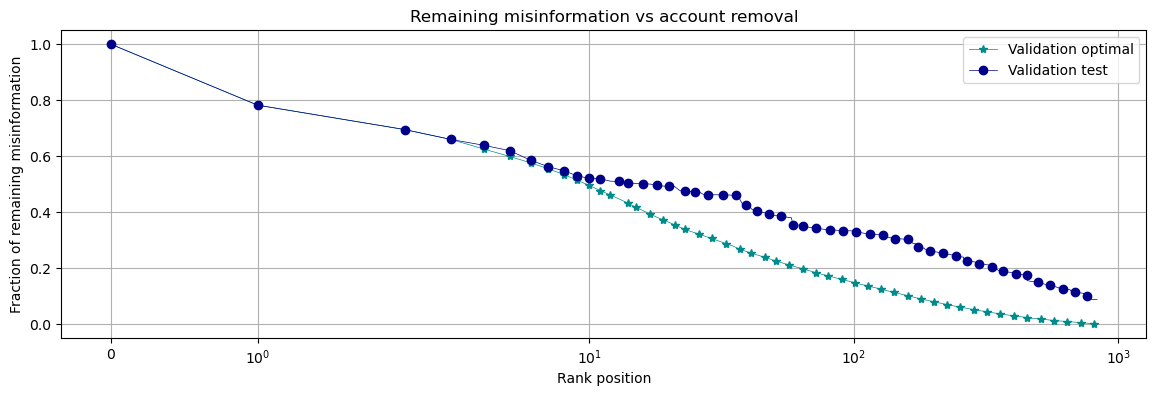

In [22]:
plot_dismantling_graph(v_dismantled_df, ["darkcyan", "darkblue"], ["*-", "o-"])

### Alpha vs Delta

In [23]:
# Group by 'Alpha' and 'Delta', then find the row(s) with max 'Loss' in each group
min_loss_rows = evaluated_hparams_df.loc[evaluated_hparams_df.groupby(['Alpha', 'Delta'])['Loss'].idxmin()]

# Pivot the DataFrame
grid_search_df = min_loss_rows.pivot(index='Alpha', columns='Delta', values='Loss')

# Reorder rows and columns in ascending order
grid_search_df.sort_index(axis=0, inplace=True, ascending=False)
grid_search_df.sort_index(axis=1, inplace=True)

In [24]:
grid_search_df

Delta,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,181
Alpha,,,,,,,,,,,,,,,,,,,,,
1.0,0.332494,0.585137,0.220862,0.215049,0.288333,0.299472,0.275493,0.231899,0.240383,0.219347,...,0.136272,0.125940,0.137726,0.118106,0.115531,0.120663,0.116868,0.126619,0.109961,0.048088
0.9,0.086981,0.081007,0.032526,0.055506,0.072107,0.066629,0.065925,0.063378,0.062634,0.062725,...,0.061784,0.061784,0.077451,0.074386,0.074386,0.061130,0.061296,0.072448,0.087960,0.048088
0.8,0.065345,0.059390,0.030860,0.052504,0.053083,0.052827,0.064742,0.068444,0.050430,0.049958,...,0.045737,0.053949,0.056626,0.046192,0.046192,0.045955,0.060937,0.060665,0.060903,0.048088
0.7,0.086528,0.057024,0.031343,0.031343,0.051249,0.049776,0.054939,0.067632,0.048433,0.048171,...,0.047482,0.044852,0.044403,0.042820,0.047804,0.044403,0.044403,0.045772,0.042501,0.048088
0.6,0.095239,0.058095,0.034459,0.031884,0.049374,0.049665,0.061748,0.067251,0.050000,0.049460,...,0.044744,0.046740,0.045693,0.042950,0.044532,0.045693,0.044403,0.047482,0.042950,0.048088
0.5,0.284788,0.046171,0.029832,0.029620,0.049162,0.028161,0.046840,0.027959,0.053466,0.050800,...,0.044556,0.047317,0.046143,0.043703,0.044744,0.046086,0.045693,0.047482,0.042974,0.048088
0.4,0.309083,0.045082,0.029620,0.030465,0.049162,0.029285,0.027298,0.029385,0.048904,0.049374,...,0.044556,0.046840,0.046740,0.043703,0.045847,0.046840,0.045374,0.046414,0.043703,0.048088
0.3,0.345216,0.064421,0.050819,0.050819,0.049767,0.028677,0.028518,0.031088,0.048827,0.049162,...,0.044556,0.046538,0.046915,0.043703,0.045847,0.046840,0.025832,0.043707,0.043703,0.048088
0.2,0.348208,0.064421,0.050819,0.050819,0.049767,0.049432,0.028518,0.058127,0.049064,0.049399,...,0.044556,0.058819,0.046915,0.043703,0.045847,0.065766,0.025832,0.043707,0.043703,0.052088


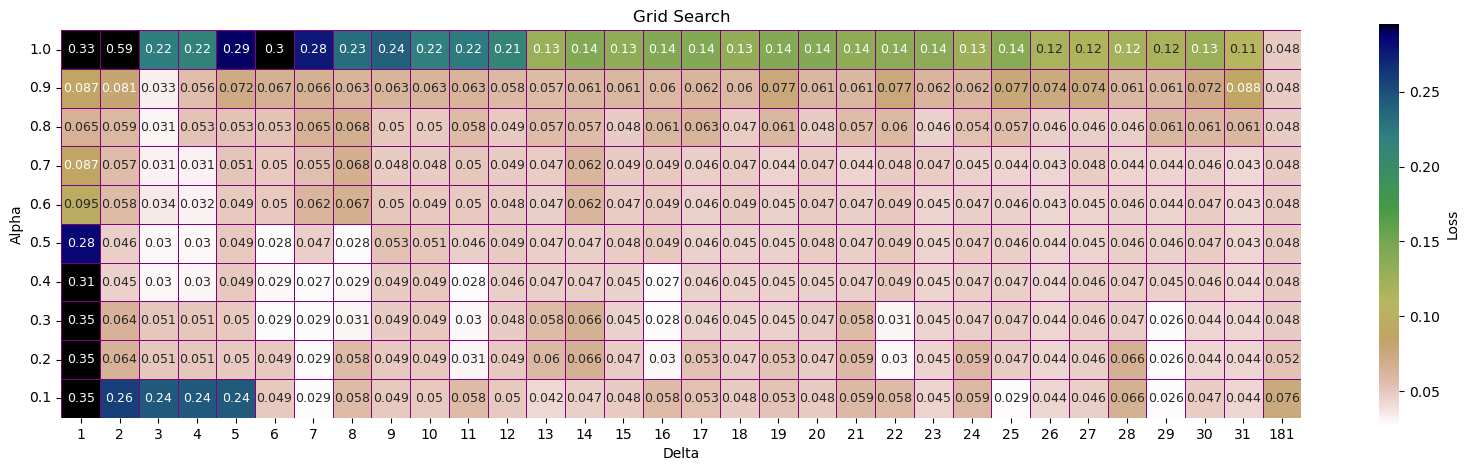

In [25]:
plot_grid_search_heatmap(grid_search_df, annot_size=9, palette="gist_earth")

### Setting Hyperparameters for Training Phase

In [26]:
# Show best and worse hyperparameters found
best_hparams = list(evaluated_hparams_df.iloc[0].values)
worse_hparams = list(evaluated_hparams_df.iloc[-1].values)
print(f"Best hyperparameters: α = {best_hparams[0]}, β = {best_hparams[1]}, γ = {best_hparams[2]}, δ = {best_hparams[3]}")
print(f"Worse hyperparameters: α = {worse_hparams[0]}, β = {worse_hparams[1]}, γ = {worse_hparams[2]}, δ = {worse_hparams[3]}")

Best hyperparameters: α = 0.2, β = -1.0, γ = -1.0, δ = 29.0
Worse hyperparameters: α = 1.0, β = -1.0, γ = -1.0, δ = 2.0


In [27]:
# Set the best and the worse hyperparameters for global usage
BEST_ALPHA, BEST_BETA, BEST_GAMMA, BEST_DELTA = best_hparams[:-1]
WORSE_ALPHA, WORSE_BETA, WORSE_GAMMA, WORSE_DELTA = worse_hparams[:-1]

## Training phase

In [28]:
# Baseline (FIB-index)
fib_engine_baseline = TFIBEngine(
    reshare_key=lambda x: x[0],
    author_key=lambda x: x[2],
    original_post_key=lambda x: x[3],
    original_author_key=lambda x: x[4],
    timestamp_key=lambda x: x[1],
    flag_key=lambda x: x[5],
    credibility_threshold = CREDIBILITY_THR,
    alpha=BEST_ALPHA,
    beta=BEST_BETA,
    gamma=BEST_GAMMA,
    delta=BEST_DELTA,
    use_original_rtt=USE_ORIGINAL_RTT,
    enable_repost_count_scaling=False)

# Best hyperparameters (TFIB-index)
tfib_engine_best = TFIBEngine(
    reshare_key=lambda x: x[0],
    author_key=lambda x: x[2],
    original_post_key=lambda x: x[3],
    original_author_key=lambda x: x[4],
    timestamp_key=lambda x: x[1],
    flag_key=lambda x: x[5],
    credibility_threshold = CREDIBILITY_THR,
    alpha=BEST_ALPHA,
    beta=BEST_BETA,
    gamma=BEST_GAMMA,
    delta=BEST_DELTA,
    use_original_rtt=USE_ORIGINAL_RTT,
    enable_repost_count_scaling=False)

# Worse hyperparameters (TFIB-index)
tfib_engine_worse = TFIBEngine(
    reshare_key=lambda x: x[0],
    author_key=lambda x: x[2],
    original_post_key=lambda x: x[3],
    original_author_key=lambda x: x[4],
    timestamp_key=lambda x: x[1],
    flag_key=lambda x: x[5],
    credibility_threshold = CREDIBILITY_THR,
    alpha=WORSE_ALPHA,
    beta=WORSE_BETA,
    gamma=WORSE_GAMMA,
    delta=WORSE_DELTA,
    use_original_rtt=USE_ORIGINAL_RTT,
    enable_repost_count_scaling=False)

# Create the data for model training
train_set_tuplelist = list(train_set_df.itertuples(index=False))

# Train both models
fib_engine_baseline.fit(train_set_tuplelist) # Baseline
tfib_engine_best.time_fit(train_set_tuplelist) # Proposed (Best settings)
tfib_engine_worse.time_fit(train_set_tuplelist) # Proposed (Worse settings)

In [29]:
# Show FIB-i Top-10 (Baseline)
list(fib_engine_baseline.get_rank().items())[:10]

[('1683455144', 71.0),
 ('245969509', 38.0),
 ('1248216384577953792', 30.0),
 ('1032615842', 28.0),
 ('1322629376421355521', 25.0),
 ('910827588', 23.0),
 ('1063806444380798976', 20.0),
 ('454365633', 20.0),
 ('473801195', 16.0),
 ('1006071437168390144', 13.0)]

In [30]:
# Show TFIB-i Top-10 (Proposed best)
list(tfib_engine_best.get_rank().items())[:10]

[('1683455144', 26.030527),
 ('1248216384577953792', 13.379981),
 ('1032615842', 10.271693),
 ('245969509', 8.19113),
 ('500882938', 7.01527),
 ('454365633', 6.7484417),
 ('1322629376421355521', 5.4266367),
 ('33284443', 4.987712),
 ('104761548', 4.830336),
 ('221681749', 4.623168)]

In [31]:
# Show TFIB-i Top-10 (Proposed worse)
list(tfib_engine_worse.get_rank().items())[:10]

[('1683455144', 3.0),
 ('1032615842', 3.0),
 ('1366505333523443715', 3.0),
 ('1322629376421355521', 2.0),
 ('1192636619167322112', 2.0),
 ('104761548', 2.0),
 ('537079214', 2.0),
 ('2513788304', 2.0),
 ('1006071437168390144', 2.0),
 ('500882938', 2.0)]

### Build the Test Ground Truth Ranking

In [32]:
# Build retweet networks from test set (low credibility retweets only)
test_retweets_network = get_retweet_network(
    test_set_df[test_set_df.credibility_score <= CREDIBILITY_THR],
    rt_UserID_col="retweeted_user_id",
    userID_col="user_id",
    rating_col="credibility_score")

# Raw optimal ranking
test_optimal_ranking = get_optimal_ranking(test_retweets_network).set_index("node")

# Conbine the scores to get a single score that keep the ordering
test_optimal_ranking['combined'] = (
    test_optimal_ranking["outgoing_weight"] +
    test_optimal_ranking["incoming_weight"] / 
    (test_optimal_ranking["incoming_weight"].max() + 1))

# Get the optimal ranking as a dict (ground truth)
test_optimal_ranking = test_optimal_ranking.to_dict()["combined"]

In [33]:
# Show optimal ranking Top-10
list(test_optimal_ranking.items())[:10]

[('1683455144', 8130.125714285714),
 ('1248216384577953792', 3731.057142857143),
 ('1241675979929661442', 1357.5314285714285),
 ('1032615842', 1306.4914285714285),
 ('1173682089637625856', 944.0),
 ('454365633', 779.0057142857142),
 ('775343030421291008', 766.0),
 ('245969509', 726.1028571428571),
 ('874606845511565313', 503.01714285714286),
 ('761787475', 449.0057142857143)]

## Test Loss

In [34]:
# Evaluate the loss with the test set
FIB_loss_baseline = nDCG_loss(test_optimal_ranking, fib_engine_baseline.get_rank(), k=NDCG_AT)
TFIB_loss_best = nDCG_loss(test_optimal_ranking, tfib_engine_best.get_rank(), k=NDCG_AT)
TFIB_loss_worse = nDCG_loss(test_optimal_ranking, tfib_engine_worse.get_rank(), k=NDCG_AT)

# Show results
print(f"FIB-i Ranking Loss (Baseline): {FIB_loss_baseline}")
print(f"TFIB-i Ranking Loss (Best): {TFIB_loss_best}")
print(f"TFIB-i Ranking Loss (Worse): {TFIB_loss_worse}")

FIB-i Ranking Loss (Baseline): 0.12356553648008517
TFIB-i Ranking Loss (Best): 0.08782006535711373
TFIB-i Ranking Loss (Worse): 0.5066832948716649


## Results Dataframe

In [35]:
# Build the results dictionary
test_dismantle_fn = lambda x: network_dismantle(test_retweets_network, x)

results_dict = {
    "FIB-i Baseline": [pair[1] for pair in test_dismantle_fn(fib_engine_baseline.get_rank())],
    f"TFIB-i (α={BEST_ALPHA}, δ={int(BEST_DELTA)})": [pair[1] for pair in test_dismantle_fn(tfib_engine_best.get_rank())],
    f"TFIB-1 (α={WORSE_ALPHA}, δ={int(WORSE_DELTA)})": [pair[1] for pair in test_dismantle_fn(tfib_engine_worse.get_rank())],
    "Optimal": [pair[1] for pair in test_dismantle_fn(test_optimal_ranking)]
}

# Adjust the tracks lenght by replicating the last value
make_lists_same_length(results_dict)

In [36]:
# Convert to dataframe
results_df = pd.DataFrame(results_dict)
results_df.head(10)

,FIB-i Baseline,"TFIB-i (α=0.2, δ=29)","TFIB-1 (α=1.0, δ=2)",Optimal
0,1.000000,1.000000,1.000000,1.000000
1,0.789437,0.789437,0.789437,0.789437
2,0.770460,0.692608,0.754434,0.692608
3,0.673631,0.657735,0.753243,0.657243
4,0.638809,0.638809,0.751560,0.622369
5,0.637126,0.634408,0.751482,0.597981
6,0.630913,0.614317,0.748142,0.577864
7,0.629851,0.612634,0.746822,0.558058
8,0.609761,0.607741,0.742421,0.539184
9,0.600984,0.604401,0.742369,0.526110


## Hyperparameters Comparison

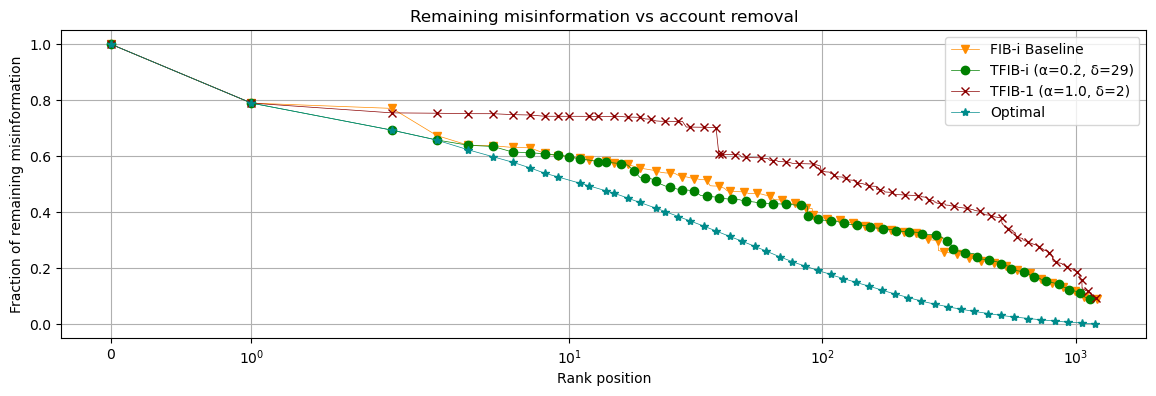

In [37]:
# Set up the plot
colors = ["darkorange", "green", "darkred", "darkcyan"]
styles = ["v-", "o-", "x-" , "*-"]

# Plot
plot_dismantling_graph(results_df, colors, styles)

## Saving Results

In [38]:
# Your dictionary
training_results = {"Alpha": BEST_ALPHA,
                    "Beta": BEST_BETA,
                    "Gamma": BEST_GAMMA,
                    "Delta": BEST_DELTA,
                    "Ranking": tfib_engine_best.get_rank()}

# Specify the file path
file_path = "data/training_results.pickle"

# Save the dictionary to disk
with open(file_path, 'wb') as f:
    pickle.dump(training_results, f)

### Results Re-Load Check

In [39]:
# Load the dictionary from disk
with open(file_path, 'rb') as f:
    loaded_results = pickle.load(f)

import pprint

pprint.pprint(loaded_results, depth=1)

{'Alpha': 0.2, 'Beta': -1.0, 'Delta': 29.0, 'Gamma': -1.0, 'Ranking': {...}}
